In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Input, Dropout, BatchNormalization, Activation
from keras import backend as K
from keras.models import Model
import datetime

In [2]:
data_path = './data/'   

train = pd.read_csv(data_path + 'train_features.csv')
train_label = pd.read_csv(data_path + 'train_labels.csv')
test = pd.read_csv(data_path + 'test_features.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

In [26]:
df = pd.merge(train,train_label, on='id', how='outer')

<AxesSubplot:>

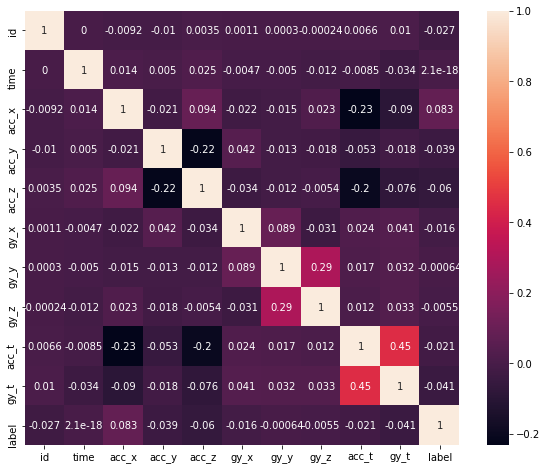

In [27]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), square=True, annot=True, ax=ax)

In [3]:
train_label.head

<bound method NDFrame.head of         id  label                          label_desc
0        0     37           Shoulder Press (dumbbell)
1        1     26                        Non-Exercise
2        2      3                  Biceps Curl (band)
3        3     26                        Non-Exercise
4        4     26                        Non-Exercise
...    ...    ...                                 ...
3120  3120     26                        Non-Exercise
3121  3121     26                        Non-Exercise
3122  3122     15  Dynamic Stretch (at your own pace)
3123  3123     26                        Non-Exercise
3124  3124      2                          Bicep Curl

[3125 rows x 3 columns]>

In [4]:
train_label[['label','label_desc']].value_counts()

label  label_desc                                  
26     Non-Exercise                                    1518
8      Device on Table                                   97
28     Plank                                             55
60     Wall Squat                                        48
18     Jump Rope                                         47
                                                       ... 
53     Triceps Kickback (knee on bench) (right arm)      13
13     Dumbbell Row (knee on bench) (right arm)          12
12     Dumbbell Row (knee on bench) (left arm)           12
52     Triceps Kickback (knee on bench) (left arm)       12
0      Arm Band Adjustment                               12
Length: 61, dtype: int64

In [5]:
train['acc_t'] = np.sqrt(train['acc_x']**2 + train['acc_y']**2 + train['acc_z']**2)
test['acc_t'] = np.sqrt(test['acc_x']**2 + test['acc_y']**2 + test['acc_z']**2)

train['gy_t'] = np.sqrt(train['gy_x']**2 + train['gy_y']**2 + train['gy_z']**2)
test['gy_t'] = np.sqrt(test['gy_x']**2 + test['gy_y']**2 + test['gy_z']**2)

In [6]:
x_train = []

for uid in tqdm(train['id'].unique()):
    temp = np.array(train[train['id'] == uid].iloc[:,2:], np.float32)
    x_train.append(temp)

x_train = np.array(x_train, np.float32)
x_train = x_train[:,:,:]

x_test = []

for uid in tqdm(test['id'].unique()):
    temp = np.array(test[test['id'] == uid].iloc[:,2:], np.float32)
    x_test.append(temp)

x_test = np.array(x_test, np.float32)
x_test = x_test[:,:,:]

100%|██████████| 782/782 [00:00<00:00, 1230.27it/s]


In [7]:
y = tf.keras.utils.to_categorical(train_label['label']) 
y.shape

(3125, 61)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_train, y, test_size=0.3, stratify=y, random_state=42, shuffle=True)

In [9]:
X_train.shape

(2187, 600, 8)

In [10]:
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [11]:
true_false = train_label['label']!=26
true_false[0]

True

In [12]:
for c in range(2):
    for a in tqdm(range(50)):
        plus_data = []


        for i in range(2187):
            if (y_train[i][26] != 1):
                shift_data = np.roll(X_train[i], int(random.random()*600), axis=0)
                plus_data.append(shift_data)

        plus_data_label = []

        for i in range(2187):
            if (y_train[i][26] != 1):
                shift_label = y_train[i]
                plus_data_label.append(shift_label)

        plus_data = np.array(plus_data, np.float32)
        plus_data_label = np.array(plus_data_label, np.float32)

        X_train= np.vstack([X_train, plus_data])
        y_train=np.vstack([y_train, plus_data_label])

    for b in range(1):
        plus_data = []

        for i in range(2187):
            if (y_train[i][26] == 1):
                shift_data = np.roll(X_train[i], int(random.random()*600), axis=0)
                plus_data.append(shift_data)

        plus_data_label = []

        for i in range(2187):
            if (y_train[i][26] == 1):
                shift_label = y_train[i]
                plus_data_label.append(shift_label)

        plus_data = np.array(plus_data, np.float32)
        plus_data_label = np.array(plus_data_label, np.float32)

        X_train= np.vstack([X_train, plus_data])
        y_train=np.vstack([y_train, plus_data_label])

100%|██████████| 50/50 [00:34<00:00,  1.46it/s]


In [13]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(600,8)))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(LSTM(128, return_sequences=True))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(LSTM(128, return_sequences=True))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(61, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 600, 256)          271360    
_________________________________________________________________
activation (Activation)      (None, 600, 256)          0         
_________________________________________________________________
dropout (Dropout)            (None, 600, 256)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 600, 128)          197120    
_________________________________________________________________
activation_1 (Activation)    (None, 600, 128)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 600, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 600, 128)          1

In [15]:
log_dir = "./Exercise_Tensorboard/Exercise_Tensorboard" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [16]:
X_train.shape

(116811, 600, 8)

In [17]:
y_train.shape

(116811, 61)

In [18]:
X_test.shape

(938, 600, 8)

In [19]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [20]:
model.fit(X_train,y_train, epochs=50, batch_size=128, shuffle=True , validation_data=(X_test, y_test), callbacks=[tensorboard_callback])

Epoch 1/50
913/913 [==============================] - 249s 273ms/step - loss: 3.1781 - accuracy: 0.1346 - val_loss: 3.0659 - val_accuracy: 0.0864
Epoch 2/50
913/913 [==============================] - 245s 268ms/step - loss: 2.7299 - accuracy: 0.1871 - val_loss: 2.8934 - val_accuracy: 0.1141
Epoch 3/50
913/913 [==============================] - 244s 267ms/step - loss: 2.4705 - accuracy: 0.2301 - val_loss: 2.8583 - val_accuracy: 0.1471
Epoch 4/50
913/913 [==============================] - 244s 267ms/step - loss: 2.2421 - accuracy: 0.2671 - val_loss: 2.9753 - val_accuracy: 0.1727
Epoch 5/50
913/913 [==============================] - 251s 274ms/step - loss: 2.0633 - accuracy: 0.2977 - val_loss: 2.7858 - val_accuracy: 0.3017
Epoch 6/50
913/913 [==============================] - 252s 276ms/step - loss: 1.8565 - accuracy: 0.3371 - val_loss: 2.8305 - val_accuracy: 0.2143
Epoch 7/50
913/913 [==============================] - 247s 271ms/step - loss: 1.7163 - accuracy: 0.3767 - val_loss: 2.7206 -

In [27]:
print(model.evaluate(X_test, y_test, batch_size=128))

8/8 [==============================] - 0s 45ms/step - loss: 2.5089 - accuracy: 0.5064
[2.5089025497436523, 0.5063965916633606]


In [ ]:
prediction=model.predict(x_test)

In [ ]:
submission.iloc[:,1:]=prediction

In [ ]:
submission

In [ ]:
submission.to_csv('./output/PlusData_LSTM_210201_01.csv', index=False)